## 0. Funções

In [46]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# FUNCTIONS #

#function to plot in and target data
def plotData(data, names):
    plt.figure()
    n_graphs = len(data.T)
    for i in range(n_graphs):
        plt.subplot(n_graphs,1,i+1)
        plt.plot(data[names[i]])
        plt.ylabel(names[i])

#function to scale the dataset
def scaleData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].min())
                          / (data.iloc[:,i].max() - data.iloc[:,i].min()))
    return s_data

#function to standardize the dataset
def standardizeData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].mean())
                          / data.iloc[:,i].std())
    
    return s_data

def reStandData(data,y,n_inputs,n_outputs):
    s_y = y.copy()
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    #y_m = np.matrix(y)
    l = len(outs.T)
    for i in range(l):
        s_y[:,i] = y[:,i] * outs.iloc[:,i].std() + outs.iloc[:,i].mean()
        
    
    return np.array(s_y)

def plotOutputs(data, y, n_inputs, n_outputs):
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    l = len(outs.T)
    for i in range(l):
        plt.figure(i)
        #plt.subplot(n_outputs,1,i+1)
        plt.plot(outs.iloc[:,i],color="blue") 
        plt.plot(y[:,i], color="red")
        plt.ylabel(outs.columns[i]), plt.xlabel('Sample');

def addFeatures(data, n, names):
    l = len(data.T)
    for i in range(l):
        for j in range(n):
            #names for delayed inputs
            #Ex: Input Gas Rate (-1)...
            txt = names[i]+' (-'+str(j+1)+')'
            if j == 0:
                data[txt] = data[names[i]].shift(periods=1)
            else:
                txt2 = names[i]+' (-'+str(j)+')'
                data[txt] = data[txt2].shift(periods=1)
            
            data.loc[0,txt] = data.loc[1,txt]
            
        
    
    return data
            

def getPairs(fData, n_inputs, n_outputs):
    x = fData.iloc[:,0:n_inputs]
    delayed_x = fData.iloc[:,n_outputs+1:]
    X = pd.concat([x,delayed_x], axis=1)
    y = fData.iloc[:,n_inputs:n_inputs+n_outputs]
    return X,y

def getMSE(data, y, n_inputs, n_outputs):
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    l = len(outs.T)
    MSEs = np.zeros(l)
    for i in range(l):
        MSEs[i] = mean_squared_error(y_pred[:,i],outs.iloc[:,i])
    
    return MSEs
    

## 1. Processamento dos Dados

In [47]:

#path to access the dataset .txt or .csv
path = '../Data/Online Prediction/FCCU.txt'

#names of the input and target data
names=['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'Gasoline', 'Light Diesel Oil', 'Liquified Petroleum Gas']

data = pd.read_csv(path, header=None, sep=' ',names=names)


scaledData = scaleData(data)

#dados padronizados
standardizedData = standardizeData(data)

#plotData(scaledData,names)
#plotData(standardizedData,names)

delayed_order = 2

featuredData = addFeatures(standardizedData,delayed_order,names)

featuredData.head(3)

u1        u2        u3        u4        u5        u6  Gasoline  \
0 -0.995034  1.221345  0.593116  1.651327  1.469823 -0.927583  0.490411   
1 -0.082838 -0.688462 -0.487297  0.048206 -0.771428  0.688022  0.490411   
2 -0.826109  1.185978  0.944878  1.942803  1.857200 -0.927583  0.490411   

   Light Diesel Oil  Liquified Petroleum Gas   u1 (-1)  ...   u5 (-1)  \
0          -1.08886                 1.917658 -0.995034  ...  1.469823   
1          -0.04516                 1.192434 -0.995034  ...  1.469823   
2          -0.56701                 0.467211 -0.082838  ... -0.771428   

    u5 (-2)   u6 (-1)   u6 (-2)  Gasoline (-1)  Gasoline (-2)  \
0  1.469823 -0.927583 -0.927583       0.490411       0.490411   
1  1.469823 -0.927583 -0.927583       0.490411       0.490411   
2  1.469823  0.688022 -0.927583       0.490411       0.490411   

   Light Diesel Oil (-1)  Light Diesel Oil (-2)  Liquified Petroleum Gas (-1)  \
0               -1.08886               -1.08886                      1.917658   
1               -1.08886               -1.08886                      1.917658   
2               -0.04516               -1.08886                      1.192434   

   Liquified Petroleum Gas (-2)  
0                      1.917658  
1                      1.917658  
2                      1.917658  

[3 rows x 27 columns]

## 2. Treinamentos

### 2.1 Treinamento com RNA - MLP

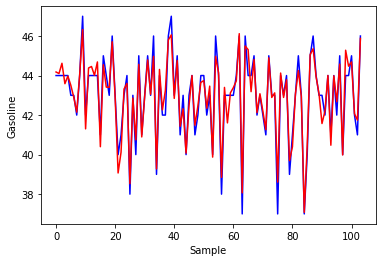

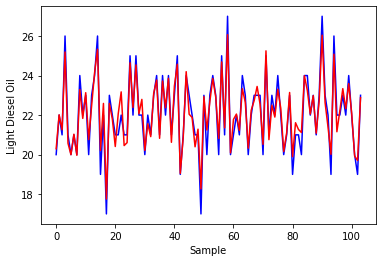

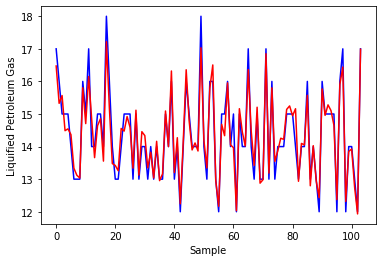

In [39]:
# Train and estimate model performance
from sklearn.model_selection import cross_val_predict
# Import neural network for regression
from sklearn.neural_network import MLPRegressor
# Import function for cross-validation
from sklearn.model_selection import cross_val_score


#number of inputs and outputs of the model
n_inputs = 6
n_outs = 3

#net parameters
n_neurons = 10000
cv = 10


#pairs of data X (input) and y (target)
X,y = getPairs(featuredData,n_inputs, n_outs)

#mlp with 1 hidden layer and 18 neurons 
mlp = MLPRegressor(hidden_layer_sizes=(n_neurons))
y_pred = cross_val_predict(mlp,X,y,cv=cv)

# Rescale prediction

y_pred = reStandData(data,y_pred,n_inputs,n_outs)

# Plot

plotOutputs(data,y_pred,n_inputs,n_outs)
MSE = getMSE(data,y_pred,n_inputs,n_outs)

### 2.2 Treinamento com SVR

In [54]:
# Import model
from sklearn.svm import SVR

#number of inputs and outputs of the model
n_inputs = 6
n_outs = 3

#net parameters
n_neurons = 10000
cv = 10


#pairs of data X (input) and y (target)
X,y = getPairs(featuredData,n_inputs, n_outs)

y_pred = cross_val_predict(SVR(),X,y,cv=cv)

# Rescale prediction

#y_pred = reStandData(data,y_pred,n_inputs,n_outs)

# Plot

#plotOutputs(data,y_pred,n_inputs,n_outs)
#MSE = getMSE(data,y_pred,n_inputs,n_outs)


ValueError: bad input shape (93, 3)

In [53]:
y_pred

array([ 2.78281513e-01,  4.32602941e-01,  6.03315446e-01,  2.30294603e-01,
        2.56195290e-01,  9.35502235e-02,  2.46100366e-02, -3.41438923e-01,
        4.36086774e-01,  1.34257486e+00, -8.85710838e-01,  4.41959907e-01,
        6.31032421e-01,  5.90899623e-01,  6.66368521e-01, -8.71223352e-01,
        5.42039449e-01,  1.43101694e-01, -5.47856946e-02,  5.59558574e-01,
       -8.95483659e-02, -1.63825955e+00, -1.05623241e+00,  4.13023782e-01,
        4.01585537e-01, -2.12007378e+00,  1.55224874e-01, -6.78548371e-01,
        8.02911190e-01, -6.04554852e-01,  7.97166879e-03,  6.91063021e-01,
        7.15585070e-03,  8.13665436e-01, -1.42280324e+00,  5.37430446e-01,
       -1.64283109e-01,  7.85399819e-02,  1.13394192e+00,  9.28358813e-01,
        7.14612095e-02,  6.81553523e-01, -4.79453368e-01, -2.60583104e-01,
       -1.14892093e+00, -1.51626218e-01,  5.83001977e-01, -4.02512128e-01,
       -9.34804909e-02,  2.26020947e-01,  2.52506102e-01,  1.68398475e-01,
        3.74889192e-01, -

In [50]:
X.shape

(104, 29)